In [ ]:
from google.colab import files

uploaded = files.upload()

Saving DCGAN.zip to DCGAN.zip


In [ ]:
import zipfile
import os

In [ ]:
with zipfile.ZipFile("/content/DCGAN.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
input_folder='/content/data_faces'

In [ ]:
splitfolders.ratio(input_folder, output='/content/data', seed=42, 
                   ratio=(.7,.2, .1), group_prefix=None)

Copying files: 1289 files [00:00, 8398.93 files/s]


In [ ]:
splitfolders.fixed(input_folder, output='/content/data', seed=42, 
                   fixed=(35, 20), oversample=False, group_prefix=None)

Copying files: 1289 files [00:00, 6532.00 files/s]


In [ ]:
import numpy as np
from collections import OrderedDict
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from functools import reduce
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
%config InlineBackend.figure_format = 'retina'
train_on_gpu = torch.cuda.is_available()

In [ ]:
def DataConstructor2000(path_to_train, path_to_test, classes=None, num_workers=4, batch_size=12, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([224,224]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=6, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [ ]:
train_loader, valid_loader,test_loader, classes = DataConstructor2000(path_to_train='/content/data/train',path_to_test='/content/data/test',
                                                                       classes=['Fake','Real'],num_workers=40, batch_size=16, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(16, 3, 224, 224)


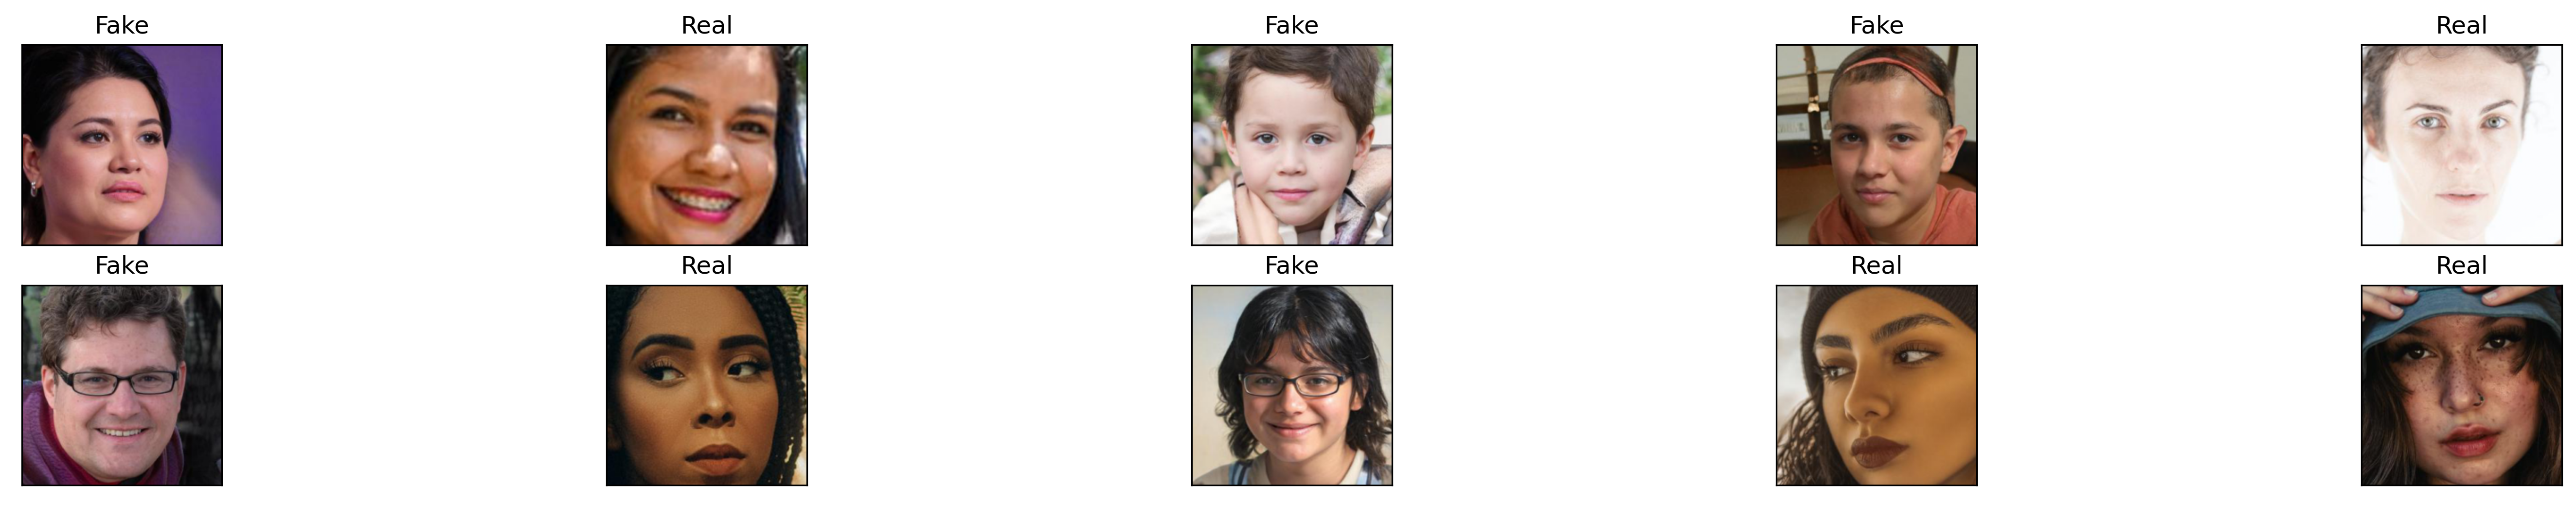

In [ ]:
def imshow(img):
#     img = img / 2 + 0.5  # unnormalize if you added normalization in the transformation step
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
class MaxPoolPad(nn.Module):

    def __init__(self):
        super(MaxPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:].contiguous()
        return x


class AvgPoolPad(nn.Module):

    def __init__(self, stride=2, padding=1):
        super(AvgPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.AvgPool2d(3, stride=stride, padding=padding, count_include_pad=False)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:].contiguous()
        return x


class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, dw_kernel, dw_stride, dw_padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise_conv2d = nn.Conv2d(in_channels, in_channels, dw_kernel,
                                          stride=dw_stride,
                                          padding=dw_padding,
                                          bias=bias,
                                          groups=in_channels)
        self.pointwise_conv2d = nn.Conv2d(in_channels, out_channels, 1, stride=1, bias=bias)

    def forward(self, x):
        x = self.depthwise_conv2d(x)
        x = self.pointwise_conv2d(x)
        return x


class BranchSeparables(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, name=None, bias=False):
        super(BranchSeparables, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, in_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(in_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(in_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)
        self.name = name

    def forward(self, x):
        x = self.relu(x)
        if self.name == 'specific':
            x = nn.ZeroPad2d((1, 0, 1, 0))(x)
        x = self.separable_1(x)
        if self.name == 'specific':
            x = x[:, :, 1:, 1:].contiguous()

        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesStem(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super(BranchSeparablesStem, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(out_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.separable_1(x)
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesReduction(BranchSeparables):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, z_padding=1, bias=False):
        BranchSeparables.__init__(self, in_channels, out_channels, kernel_size, stride, padding, bias)
        self.padding = nn.ZeroPad2d((z_padding, 0, z_padding, 0))

    def forward(self, x):
        x = self.relu(x)
        x = self.padding(x)
        x = self.separable_1(x)
        x = x[:, :, 1:, 1:].contiguous()
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class CellStem0(nn.Module):
    def __init__(self, stem_filters, num_filters=42):
        super(CellStem0, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2)
        self.comb_iter_0_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, bias=False)
        self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x1 = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x1)
        x_comb_iter_0_right = self.comb_iter_0_right(x)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x1)
        x_comb_iter_1_right = self.comb_iter_1_right(x)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x1)
        x_comb_iter_2_right = self.comb_iter_2_right(x)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x1)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class CellStem1(nn.Module):

    def __init__(self, stem_filters, num_filters):
        super(CellStem1, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(2*self.num_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, name='specific', bias=False)
        self.comb_iter_0_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, name='specific', bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, name='specific', bias=False)
        # self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_4_right = MaxPoolPad()

    def forward(self, x_conv0, x_stem_0):
        x_left = self.conv_1x1(x_stem_0)

        x_relu = self.relu(x_conv0)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_right = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_comb_iter_0_left = self.comb_iter_0_left(x_left)
        x_comb_iter_0_right = self.comb_iter_0_right(x_right)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_right)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_left)
        x_comb_iter_2_right = self.comb_iter_2_right(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_left)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class FirstCell(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(FirstCell, self).__init__()
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(out_channels_left * 2, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_relu = self.relu(x_prev)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_left = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class NormalCell(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(NormalCell, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_left, out_channels_left, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell0(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell0, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)
        self.comb_iter_0_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 3, 1, 1, bias=False)
        self.comb_iter_4_right = MaxPoolPad()

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell1(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell1, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, name='specific', bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, name='specific', bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, name='specific', bias=False)
        # self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_4_right =MaxPoolPad()

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class NASNetAMobile(nn.Module):
    """NASNetAMobile (4 @ 1056) """

    def __init__(self, num_classes=1001, stem_filters=32, penultimate_filters=1056, filters_multiplier=2):
        super(NASNetAMobile, self).__init__()
        self.num_classes = num_classes
        self.stem_filters = stem_filters
        self.penultimate_filters = penultimate_filters
        self.filters_multiplier = filters_multiplier

        filters = self.penultimate_filters // 24
        # 24 is default value for the architecture

        self.conv0 = nn.Sequential()
        self.conv0.add_module('conv', nn.Conv2d(in_channels=3, out_channels=self.stem_filters, kernel_size=3, padding=0, stride=2,
                                                bias=False))
        self.conv0.add_module('bn', nn.BatchNorm2d(self.stem_filters, eps=0.001, momentum=0.1, affine=True))

        self.cell_stem_0 = CellStem0(self.stem_filters, num_filters=filters // (filters_multiplier ** 2))
        self.cell_stem_1 = CellStem1(self.stem_filters, num_filters=filters // filters_multiplier)

        self.cell_0 = FirstCell(in_channels_left=filters, out_channels_left=filters//2, # 1, 0.5
                                in_channels_right=2*filters, out_channels_right=filters) # 2, 1
        self.cell_1 = NormalCell(in_channels_left=2*filters, out_channels_left=filters, # 2, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1
        self.cell_2 = NormalCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1
        self.cell_3 = NormalCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1

        self.reduction_cell_0 = ReductionCell0(in_channels_left=6*filters, out_channels_left=2*filters, # 6, 2
                                               in_channels_right=6*filters, out_channels_right=2*filters) # 6, 2

        self.cell_6 = FirstCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                in_channels_right=8*filters, out_channels_right=2*filters) # 8, 2
        self.cell_7 = NormalCell(in_channels_left=8*filters, out_channels_left=2*filters, # 8, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2
        self.cell_8 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2
        self.cell_9 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2

        self.reduction_cell_1 = ReductionCell1(in_channels_left=12*filters, out_channels_left=4*filters, # 12, 4
                                               in_channels_right=12*filters, out_channels_right=4*filters) # 12, 4

        self.cell_12 = FirstCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=16*filters, out_channels_right=4*filters) # 16, 4
        self.cell_13 = NormalCell(in_channels_left=16*filters, out_channels_left=4*filters, # 16, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4
        self.cell_14 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters, # 24, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4
        self.cell_15 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters, # 24, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4

        self.relu = nn.ReLU()
        self.avg_pool = nn.AvgPool2d(7, stride=1, padding=0)
        self.dropout = nn.Dropout()
        self.last_linear = nn.Linear(24*filters, self.num_classes)

    def features(self, input):
        x_conv0 = self.conv0(input)
        x_stem_0 = self.cell_stem_0(x_conv0)
        x_stem_1 = self.cell_stem_1(x_conv0, x_stem_0)

        x_cell_0 = self.cell_0(x_stem_1, x_stem_0)
        x_cell_1 = self.cell_1(x_cell_0, x_stem_1)
        x_cell_2 = self.cell_2(x_cell_1, x_cell_0)
        x_cell_3 = self.cell_3(x_cell_2, x_cell_1)

        x_reduction_cell_0 = self.reduction_cell_0(x_cell_3, x_cell_2)

        x_cell_6 = self.cell_6(x_reduction_cell_0, x_cell_3)
        x_cell_7 = self.cell_7(x_cell_6, x_reduction_cell_0)
        x_cell_8 = self.cell_8(x_cell_7, x_cell_6)
        x_cell_9 = self.cell_9(x_cell_8, x_cell_7)

        x_reduction_cell_1 = self.reduction_cell_1(x_cell_9, x_cell_8)

        x_cell_12 = self.cell_12(x_reduction_cell_1, x_cell_9)
        x_cell_13 = self.cell_13(x_cell_12, x_reduction_cell_1)
        x_cell_14 = self.cell_14(x_cell_13, x_cell_12)
        x_cell_15 = self.cell_15(x_cell_14, x_cell_13)
        return x_cell_15

    def logits(self, features):
        x = self.relu(features)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def nasnetamobile(num_classes=2):
    model = NASNetAMobile(num_classes=num_classes)
    return model.cuda()

In [ ]:
model = nasnetamobile(num_classes=2)
model = nn.DataParallel(model)

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer/secret sauce
optimizer = optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'NasnetMobile35656_gan-detector_Final.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.483616 	Validation Loss: 0.202296

Validation loss decreased (inf --> 0.202296).  Saving model ...
Epoch: 2 	Training Loss: 0.425372 	Validation Loss: 0.221303
Epoch: 3 	Training Loss: 0.315957 	Validation Loss: 0.308703
Epoch: 4 	Training Loss: 0.244548 	Validation Loss: 0.071908

Validation loss decreased (0.202296 --> 0.071908).  Saving model ...
Epoch: 5 	Training Loss: 0.144502 	Validation Loss: 0.055144

Validation loss decreased (0.071908 --> 0.055144).  Saving model ...
Epoch: 6 	Training Loss: 0.157837 	Validation Loss: 0.047481

Validation loss decreased (0.055144 --> 0.047481).  Saving model ...
Epoch: 7 	Training Loss: 0.119457 	Validation Loss: 0.039022

Validation loss decreased (0.047481 --> 0.039022).  Saving model ...
Epoch: 8 	Training Loss: 0.092436 	Validation Loss: 0.077155
Epoch: 9 	Training Loss: 0.086620 	Validation Loss: 0.030670

Validation loss decreased (0.039022 --> 0.030670).  Saving model ...
Epoch: 10 	Training Loss: 0.044096 	

In [ ]:
model.load_state_dict(torch.load('NasnetMobile35656_gan-detector_Final.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
#     print(target)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
#     print(output)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
#     print(pred)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
#         print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.002845

Test Accuracy of  Fake: 100% (24/24)
Test Accuracy of  Real: 100% (20/20)

Test Accuracy (Overall): 100% (44/44)


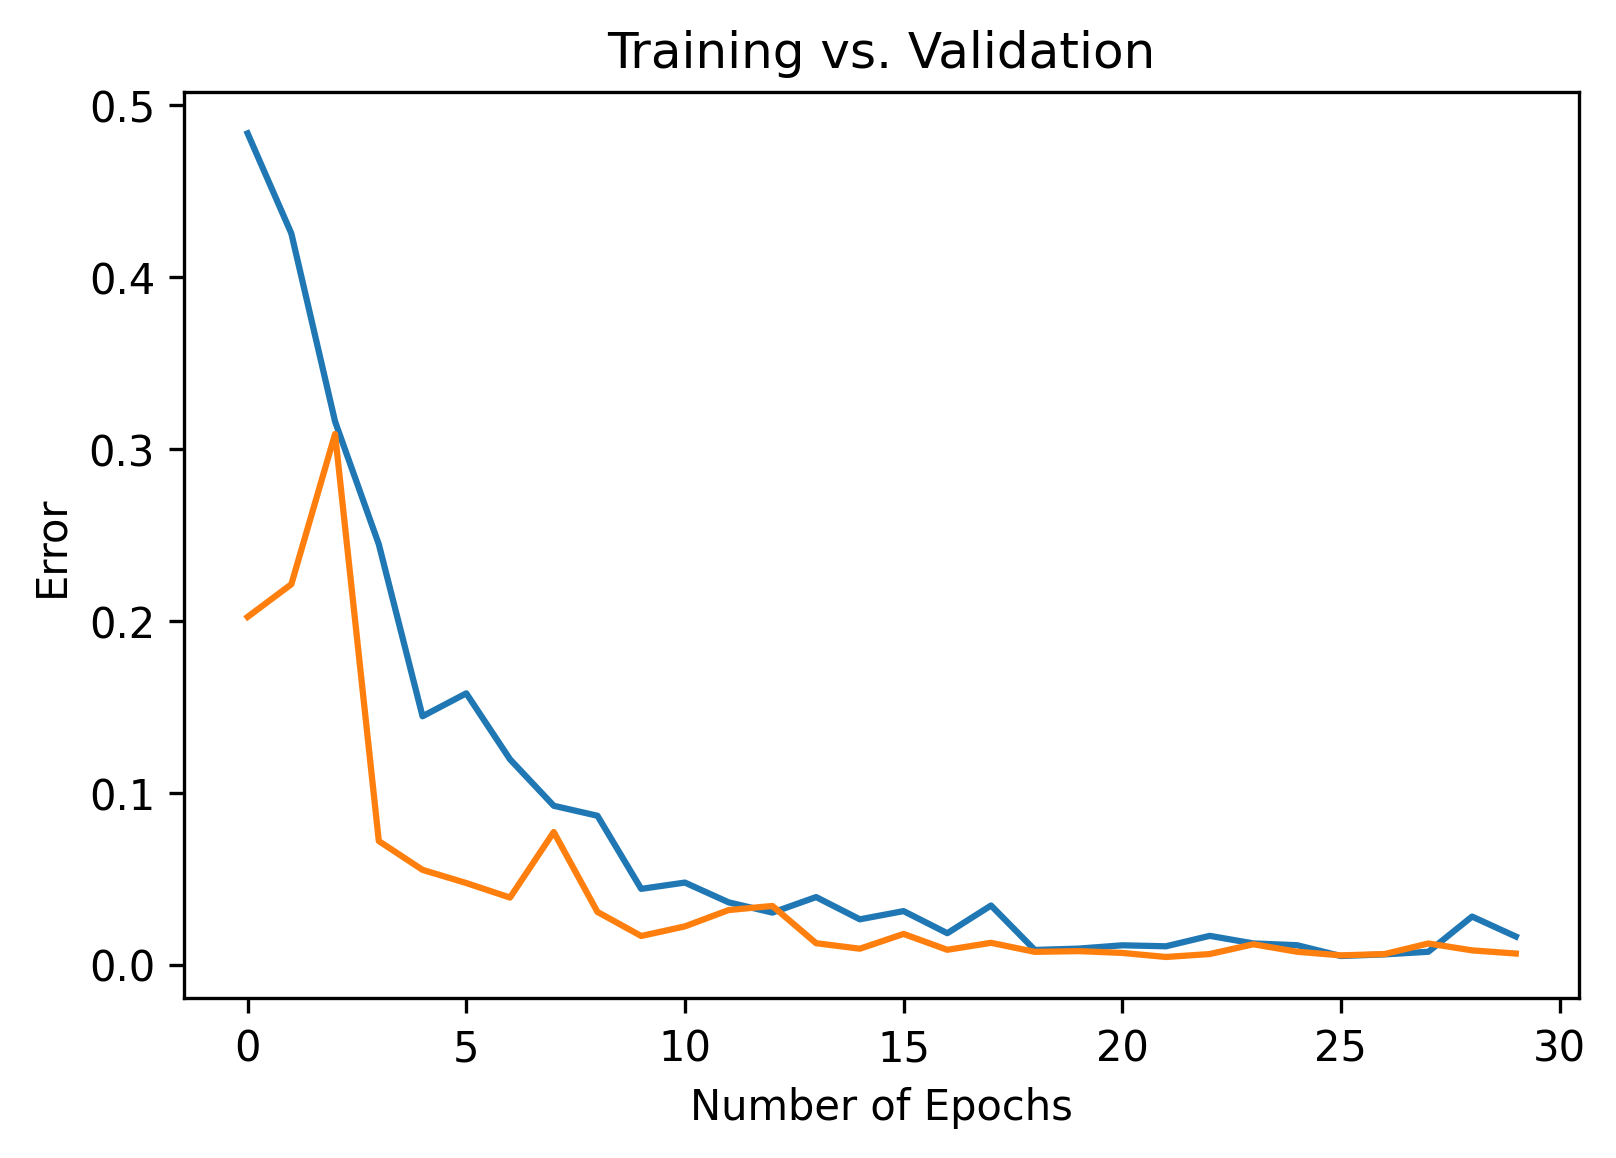

In [ ]:
plt.plot(range(epoch), training_vis)
# plt.scatter(range(epoch), training_vis)
plt.plot(range(epoch), valid_vis)
# plt.scatter(range(epoch), valid_vis)
plt.title('Training vs. Validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Error')
plt.savefig('Nasnet_line.svg')

In [ ]:
np.savetxt('NasNet_Final.txt', np.array([training_vis, valid_vis]))

(6, 3, 224, 224)


IndexError: ignored

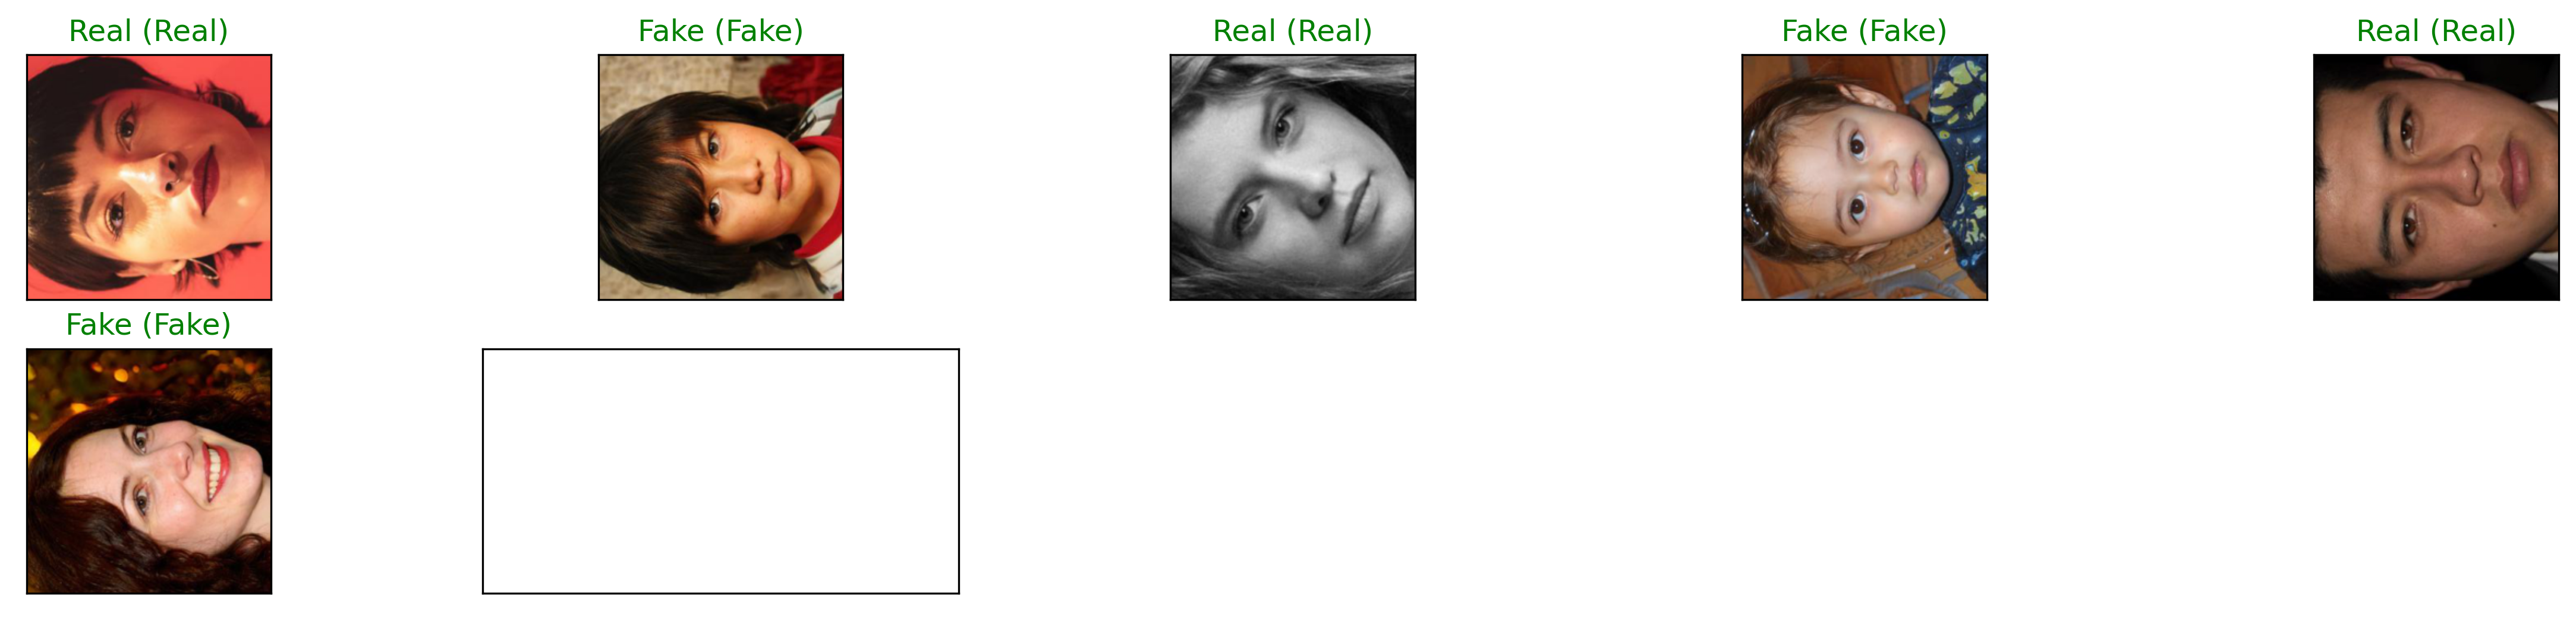

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()
print(images.shape)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.swapaxes((images[idx]),axis1=0, axis2=2))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))
plt.savefig('PNASNET_mis.pdf')